# **DEEP LEARNING PROJECT - PART 3**

# In this notebook, the first part is for LP estimations, the second part is for Deep Neural Networks

# Code for creating m-height 
### NOTE: I used the provided dataset for training, however the following code uses the LP to find m-height

In [ ]:
import torch
import itertools
import numpy as np
from scipy.optimize import linprog





def compute_m_height(G, m):
    k, n = G.shape
    print('n ',n)
    assert m <= n - k, "m must be at most n - k"
    
    # Ensure G is systematic
    I_k = np.eye(k)
    assert np.allclose(G[:, :k], I_k), "G must be systematic (first k columns should form an identity matrix)"
    
    indices = list(range(n)) #### [n> --> for any positive integer n
    Psi = list(itertools.product([-1, 1], repeat=m))  # Set of all binary vectors of length m
    
    best_height = -np.inf
    s = 0
    for a, b in itertools.permutations(indices, 2):#permutations(indices, 2):
        X_candidates = [set(comb) for comb in itertools.combinations(set(indices) - {a, b}, m - 1)] # combinations
        # print('a ',a)
        # print('b ', b)
        for X in X_candidates:
            Y = set(indices) - X - {a, b}
            # print('Y ', Y)
            # print('X ', X)
            for psi in Psi:
                tau = [a] + sorted(X) + [b] + sorted(Y)
                # print('tau ', tau)
                tau_inv = {xj: j for j, xj in enumerate(tau)}  # Calculate tau^{-1}
                # for i in range(k):
                #     print(psi[i])
                c = np.array([psi[0] * G[i, a] for i in range(k)])  # Update objective function

                A = []
                b_ineq = []

                for j in X:
                    # row = [(psi[list(X).index(j)] * G[i, tau_inv[j]] - psi[0] * G[i, a]) for i in range(k)]
                    row = [(psi[tau_inv[j]] * G[i, j] - psi[0] * G[i, a]) for i in range(k)]
                    # row = [( - psi[tau_inv[j]] * G[i, j] + psi[0] * G[i, a]) for i in range(k)]
                    A.append(row)
                    b_ineq.append(0)

                    # row_neg = [-psi[list(X).index(j)] * G[i, tau_inv[j]] for i in range(k)]
                    row_neg = [-psi[tau_inv[j]] * G[i, j] for i in range(k)]
                    # row_neg = [psi[tau_inv[j]] * G[i, j] for i in range(k)]
                    A.append(row_neg)
                    b_ineq.append(-1)
                    # b_ineq.append(1)

                for j in Y:
                    # A.append([G[i, tau_inv[j]] for i in range(k)])  # Correctly index using tau_inv
                    A.append([G[i, j] for i in range(k)])  # Correctly index using tau_inv
                    b_ineq.append(1)
                    # b_ineq.append(-1)

                    A.append([-G[i, j] for i in range(k)])
                    b_ineq.append(1)
                    # b_ineq.append(-1)

                A_eq = [[G[i, b] for i in range(k)]]
                b_eq = [1]
                # b_eq = [-1]

                res = linprog(-c, A_ub=A, b_ub=b_ineq, A_eq=A_eq, b_eq=b_eq, method='highs')

                s += 1

                if res.success:
                    best_height = max(best_height, -res.fun)
    # print(s)
    return best_height if best_height != -np.inf else None



In [ ]:
# # Example Usage:
G = np.array([[1, 0, 0.4759809, 0.993823, 0.819425], 
              [0, 1, -0.8960798 , -0.7442706, 0.3345122]])  # Systematic generator matrix

# G = np.array([[1, 0, 0.534, 0.583, -0.709, -0.053, 0.543, 0.927], 
#               [0, 1, 0.611 , -1.211, 0.233, -0.784, -0.659, -0.947]])  # Systematic generator matrix
m = 2
print("m-height:", compute_m_height(G, m))

n  5
m-height: 1.9242383477894285


# ***Code for DNNs***

## **NOTE:** the main difference between this code and the code for project 2, is that in this code, the model is more complex (2 more convolution layers + the number of channels have been increased); **another difference** is that in this model, I increased the number of modified input features from 20 to 30. **Finally**, in this notebook similar to project 2, for each setting (n,k,m), one separate model is being trained.

## **NOTE:** after these modifications, the test performance was marginally improved with respect to project 2 

# Required packages for the model

In [1]:
import torch
import numpy as np
import joblib

from torch.utils.data import DataLoader, random_split, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import torch.optim as optim

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import math
from tqdm import tqdm
import time

# Class for creating the dataset for dataloader + function for preprocessing the data

In [2]:
class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

def pre_process_data(gen_mats, nfeat = 1): # matrix of shape [n_samples, n_dims]
    struct_mat = []
    m = nn.AdaptiveAvgPool1d(nfeat)
    for item in gen_mats:
        if type(item) == np.ndarray:
            item = torch.tensor(item.astype(float))
        # if type(item) == torch.Tensor:
        #     continue
        item = item.unsqueeze(0)
        struct_mat.append(m(item))
        
    return torch.cat((struct_mat))

An explanation for the model:
Generally, the model consists of 3 components: 
- An encoder 
- - encoder itself contains 2 calls to the simple encoder which maps modified matrices (27 features in this code) and the \[n,m,k\], each to a 10 dimensional feature vector (hence, after concatanation, the input to the first conv1d layer is 20 dimensional)
- - encoder also utilizes  5 conv1d layers with avg pooling
- A Normalizing flow module (where I used planar flows for the trained model with 10 flows)
- A decoder: similar to the encoder, without the use of simple encoders 

### NOTE: the complete model is provided in VAEWithFlow class 

### NOTE: the model predicts log2($\cdot$)

In [3]:
class simple_encoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        
        self.fc1 = nn.Linear(input_dim, 2)
        self.fc2 = nn.Linear(2, output_dim)
        self.relu = nn.ReLU()
    
    def forward(self, z):
        o = self.fc1(z)
        o = self.relu(o)
        o = self.fc2(o)
        return o
    


# Planar Flow
class PlanarFlow(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.w = nn.Parameter(torch.randn(1, dim))
        self.u = nn.Parameter(torch.randn(1, dim))
        self.b = nn.Parameter(torch.randn(1))
    
    def forward(self, z):
        linear = torch.matmul(z, self.w.T) + self.b
        activation = torch.tanh(linear)
        psi = (1 - activation ** 2) * self.w
        det_jacobian = torch.abs(1 + torch.matmul(psi, self.u.T))
        log_det = torch.log(det_jacobian + 1e-6)
        z_next = z + self.u * activation
        return z_next, log_det

# Radial Flow
class RadialFlow(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.z0 = nn.Parameter(torch.randn(1, dim))
        self.alpha = nn.Parameter(torch.randn(1))
        self.beta = nn.Parameter(torch.randn(1))
        self.dim = dim
    
    def forward(self, z):
        r = torch.norm(z - self.z0, dim=1, keepdim=True)
        h = 1 / (1 + r)
        beta_h = self.beta * h
        z_next = z + beta_h * (z - self.z0)
        log_det = (self.dim - 1) * torch.log(1 + beta_h) + torch.log(1 + beta_h + self.beta * h**2)
        return z_next, log_det

# Normalizing Flow Model
class NormalizingFlow(nn.Module):
    def __init__(self, dim, num_flows=2, flow_type='planar'):
        super().__init__()
        self.flows = nn.ModuleList([PlanarFlow(dim) if flow_type == 'planar' else RadialFlow(dim) for _ in range(num_flows)])
    
    def forward(self, z0):
        log_det_sum = 0
        z = z0
        for flow in self.flows:
            z, log_det = flow(z)
            log_det_sum += log_det
        return z, log_det_sum

# Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        
        self.emnk = simple_encoder(input_dim = 3, output_dim = 10)
        self.eg = simple_encoder(input_dim = input_dim - 3, output_dim = 10)
    
#         self.conv1 = nn.Conv1d(in_channels = 1, out_channels = 16, kernel_size = 2, padding = 1)
#         self.pool1 = nn.MaxPool1d(kernel_size = 2)
#         self.conv2 = nn.Conv1d(in_channels = 16, out_channels = 64, kernel_size = 2, padding = 1) # was 32 previously - was 3 previously
#         self.pool2 = nn.MaxPool1d(kernel_size = 2)
#         self.conv3 = nn.Conv1d(in_channels = 64, out_channels = 256, kernel_size = 2, padding = 1) # was 128 previously
#         self.pool3 = nn.MaxPool1d(kernel_size = 2)
        
        
        self.conv1 = nn.Conv1d(in_channels = 1, out_channels = 32, kernel_size = 2, padding = 1)
        self.pool1 = nn.AvgPool1d(kernel_size = 2) #nn.MaxPool1d(kernel_size = 2)
        self.conv2 = nn.Conv1d(in_channels = 32, out_channels = 128, kernel_size = 2, padding = 1) # was 32 previously - was 3 previously
        self.pool2 = nn.AvgPool1d(kernel_size = 2) #nn.MaxPool1d(kernel_size = 2)
        self.conv22 = nn.Conv1d(in_channels = 128, out_channels = 128, kernel_size = 2, padding = 1)
        self.conv3 = nn.Conv1d(in_channels = 128, out_channels = 256, kernel_size = 2, padding = 1) # was 128 previously
        self.conv33 = nn.Conv1d(in_channels = 256, out_channels = 512, kernel_size = 2, padding = 1) 
#         self.conv33 = nn.Conv1d(in_channels = 256, out_channels = 256, kernel_size = 2, padding = 1) 
        self.pool3 = nn.AvgPool1d(kernel_size = 2) #nn.MaxPool1d(kernel_size = 2)
        
        self.flatten = nn.Flatten()
        
        
        
#         self.fc1 = nn.Linear(input_dim, 64)
#         self.fc1 = nn.Linear(32*5, 64)
#         self.fc1 = nn.Linear(256*3, 64) # 128 * 2 previously
#         self.fc1 = nn.Linear(256*4, 64) # 128 * 2 previously
#         self.fc1 = nn.Linear(512*4, 64) # 128 * 2 previously
#         self.fc1 = nn.Linear(256*4, 32) # 128 * 2 previously
        self.fc1 = nn.Linear(512*4, 32) # 128 * 2 previously
        self.fc11 = nn.Linear(32, 64)
        self.fc2 = nn.Linear(64, 64)
        self.mu = nn.Linear(64, latent_dim)
        self.log_var = nn.Linear(64, latent_dim)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        f1 = self.emnk(x[:,-3:])
        f2 = self.eg(x[:,:-3])
        f = torch.cat([f1,f2], axis = 1)
        
        f = f.unsqueeze(1)
        
        h = self.conv1(f)
        h = self.relu(h)
        h = self.pool1(h)

        h = self.conv2(h)
        h = self.relu(h)
        h = self.conv22(h) ##### added 
        h = self.relu(h) ##### added
        h = self.pool2(h)

        h = self.conv3(h)
        h = self.relu(h)
        h = self.conv33(h) #### added
        h = self.relu(h) #### added
        h = self.pool3(h)
        h = self.flatten(h)
#         print(h.shape)
        
        h = self.fc1(h)
        h = self.relu(h)
        h = self.dropout(h)
        h = self.fc11(h) #### added
        h = self.relu(h) #### added
        h = self.dropout(h) #### added
        h = self.fc2(h)
        h = self.relu(h)
        h = self.dropout(h)


        mu = self.mu(h)
        log_var = self.log_var(h)
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z0 = mu + eps * std
        return z0, mu, log_var

# Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        self.out = nn.Linear(64, output_dim)
    
    def forward(self, z):
        h = self.fc1(z)
        h = self.relu(h)
        h = self.dropout(h)
        h = self.fc2(h)
        h = self.relu(h)
        h = self.dropout(h) ### the following layer was not previously there....
        h = self.fc2(h)
        h = self.relu(h)
        h = self.dropout(h)

        o = self.out(h)
        return self.relu(o) # o if output is normalized, so it can be positive and # relu(o) output must be positive 

# Full VAE + Flow Model
class VAEWithFlow(nn.Module):
    def __init__(self, input_dim, latent_dim, output_dim, num_flows=2, flow_type='planar'):
        super().__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.flow = NormalizingFlow(latent_dim, num_flows, flow_type)
        self.decoder = Decoder(latent_dim, output_dim)
        self.latent_dim = latent_dim
    
    def forward(self, x):
        z0, mu, log_var = self.encoder(x)
        z_k, log_det = self.flow(z0)
        x_recon = self.decoder(z_k)
        return x_recon, z_k, mu, log_var, log_det
    
    def sample(self, num_samples=1):
        z0 = torch.randn(num_samples, self.latent_dim)
        z_k, _ = self.flow(z0)
        return self.decoder(z_k)




# function for setting the random seeds (for reproduibility purposes)

In [4]:
def set_seed(seed=42):
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU
    torch.cuda.manual_seed_all(seed)  # Multi-GPU
    np.random.seed(seed)  # NumPy
    # random.seed(seed)  # Python's random module
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
    torch.backends.cudnn.benchmark = False  # Slower, but more reproducible



### gathering all different settings in a list

In [5]:
nkm = []
for n in [9,10]:
    for k in [4,5,6]:
        for m in [2,3,4,5,6]:
            if n-k >= m:
                nkm.append([n,k,m])

nkm

[[9, 4, 2],
 [9, 4, 3],
 [9, 4, 4],
 [9, 4, 5],
 [9, 5, 2],
 [9, 5, 3],
 [9, 5, 4],
 [9, 6, 2],
 [9, 6, 3],
 [10, 4, 2],
 [10, 4, 3],
 [10, 4, 4],
 [10, 4, 5],
 [10, 4, 6],
 [10, 5, 2],
 [10, 5, 3],
 [10, 5, 4],
 [10, 5, 5],
 [10, 6, 2],
 [10, 6, 3],
 [10, 6, 4]]

# loading unmodified dataset 

In [ ]:
path = "D:\\TAMU\\courses\\spring 2025\\deep learning\\project\\New folder\\"
s_inds = np.load(path+'inds_small_dset.npy')
df = joblib.load(path + "results_dataframe.pkl")


# creating the modified datset 

In [ ]:
print('Getting targets, integers (n,k,m), and the modified matrices (all matrices will have the same number of features)')
target_vals = torch.tensor(df['result'].values)
nkm_vals = torch.tensor(df[['n','k','m']].values)
gmat_vals = pre_process_data(df['P'], nfeat=27)

print('Creating the modified features....')
modif_data = torch.cat([gmat_vals, nkm_vals], axis = 1)


# saving the modified dataset (to avoid loading the big dataset again)

In [ ]:
torch.save(modif_data, 'new_modif_data_all.pt')
torch.save(target_vals, 'target_vals_all.pt')

# Loading modified datasets

In [ ]:
target_vals = torch.load('target_vals_all.pt')
modif_data = torch.load('new_modif_data_all.pt')


In [7]:
modif_data.shape

torch.Size([10980480, 30])

## In the following block, after fixing the random seeds, for each setting (n,k,m), I first create a train/validation/test dataset, and then train a specific model for that specific dataset. Train/Validation losses and the Best model for each specific setting are saved where the name of each file ends with nkm ....
## Also for encouraging a wider prediction rather than just the mean/mode, I devided the loss with the variance of training m-heights in each batch 

In [15]:
set_seed(42)

input_dim = 30#20#13
latent_dim = 4#2#4#5
output_dim = 1
num_flows = 10#10#4
num_epochs = 60#20 * 2
flow_type = 'planar'  # Choose 'planar' or 'radial'

device = 'cuda' if torch.cuda.is_available() else 'cpu'



for item in nkm:

    n,k,m = item[0], item[1], item[2]

    data, target = modif_data[[(modif_data[:,-1]==item[2]) & (modif_data[:,-2]==item[1]) & (modif_data[:,-3]==item[0])]], target_vals[[(modif_data[:,-1]==item[2]) & (modif_data[:,-2]==item[1]) & (modif_data[:,-3]==item[0])]]
#     data, target = modif_data_s[[(modif_data_s[:,-1]==item[2]) & (modif_data_s[:,-2]==item[1]) & (modif_data_s[:,-3]==item[0])]], target_vals_s[[(modif_data_s[:,-1]==item[2]) & (modif_data_s[:,-2]==item[1]) & (modif_data_s[:,-3]==item[0])]]


    train_data, val_data, train_targets, val_targets = train_test_split(data, target, test_size=0.2, random_state=42)
    val_data, test_data, val_targets, test_targets = train_test_split(val_data, val_targets, test_size=0.5, random_state=42)

    inds = np.where(train_targets < 0.5*1e9) # removing very large values ---> can be outliers
    train_data, train_targets = train_data[inds], train_targets[inds]


    train_dataset = CustomDataset(torch.tensor(train_data), (torch.log2(torch.tensor(train_targets))))
    valid_dataset = CustomDataset(torch.tensor(val_data), torch.tensor(val_targets))
    test_dataset = CustomDataset(torch.tensor(test_data), torch.tensor(test_targets))




    batch_size = 1024 * 2 #256 * 4
    num_workers = 4
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)#, num_workers = num_workers)  # Shuffle only for training data
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)#, num_workers = num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)#, num_workers = num_workers)








    model = VAEWithFlow(input_dim, latent_dim, output_dim, num_flows, flow_type).to(torch.float64).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

    



    bperf = torch.inf
    p_var = torch.tensor(0.2)
    model.train()
    eps = 1e-5
    scale_kl = 1e-3 
    var_scale = 1e-1 * 1* 0
    tr_loss_track, val_loss_track = [],[]
    tr_loss_all, val_loss_all, tr_kl_all, mse_all= [],[],[],[]
    for epoch in range(num_epochs):
        total_loss = 0
        t_start = time.time()
        
        step = 0
        for x,y in train_loader:
            optimizer.zero_grad()
            x,y = x.to(device), y.to(device) # ---> log2 y (in train loader we have log2 y)
            y_hat, z_k, mu, log_var, log_det = model(x) # ---> log2 y hat (model is forced to predict log2 y)


            d_var = torch.std(y)
            
            loss = torch.abs(( (y+eps)-(y_hat.squeeze(-1)+eps) )) ** 2  * (1/d_var) #2 
            loss = loss.mean()
            
            ### this mse is just for checking the model's performance --> it was not used in updating the model
            mse = F.mse_loss( y, y_hat.squeeze(-1))

            ### scaling the loss for putting more weight on the accuracy of the model 
            new_loss = 1 * loss 

            ### kl divergence loss for Normalizing Flow part which is optimized by elbo (similar loss as VAE)
            ### kl divergence is scaled which is a common practice, and helps the model to converge faster
            kl_div = ((mu-0)**2 + p_var**2)/(2*torch.exp(log_var)) + log_var - math.log(p_var) - 0.5
            elbo_loss = new_loss + scale_kl * kl_div.mean() - var_scale * torch.std(y_hat) #+ mse
            elbo_loss.backward()
                    

            optimizer.step()        
            total_loss += loss.item()

            ### keeping track of different losses
            tr_kl_all.append(kl_div.mean().item())
            tr_loss_all.append(loss.item())
            mse_all.append(mse.item())
            
            step += 1
            print(f'step {step}/{len(train_loader)}, loss: {loss.item()}, kl_div: {tr_kl_all[-1]}', end = '\r')

        tr_loss_track.append(total_loss/len(train_loader))
        # print(f'Epoch: {epoch}, Train error: {tr_loss_track[-1]}')

        ### Validating the model 
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for x_val, y_val in valid_loader:
                x_val,y_val = x_val.to(device), y_val.to(device)
                y_hat, z_k, mu, log_var, log_det = model(x_val) # ---> log y hat

                # y_hat = torch.round(y_hat)
                
                # y_val = torch.log10(torch.log2(y_val)) # ---> since the model predicts the log2 y , and the validation y is not on log 
                y_val = torch.log2(y_val) # ---> since the model predicts the log2 y , and the validation y is not on log 
                
                ### again, for consistency, similar loss as in training is utilized 
                val_loss = F.mse_loss( (((y_val + eps))), ((y_hat.squeeze(-1) + eps)))
                total_val_loss += val_loss.item()
                val_loss_all.append(val_loss.item())
            
        
        total_val_loss /= len(valid_loader)
        scheduler.step()

        val_loss_track.append(total_val_loss)
        
        ### saving the loss track
        np.save(f'more_feats_kl{n}{k}{m}.npy', np.array(tr_kl_all))
        np.save(f'more_feats_vloss{n}{k}{m}.npy', np.array(val_loss_track))
        np.save(f'more_feats_tloss{n}{k}{m}.npy', np.array(tr_loss_track))
        
        if total_val_loss < bperf: 
            bperf = total_val_loss
            torch.save(model.state_dict(), f'more_feats_best_model{n}{k}{m}.pth')
        e_time = time.time()
        if epoch%1 == 0:
                print(f"Setting (n,k,m):{n}, {k}, {m} ---  epoch {epoch+1}, train Loss: {total_loss / len(train_loader)}, valid loss: {total_val_loss}, lr: {scheduler.get_last_lr()}, time: {e_time-t_start}")






/tmp/job.13464513/ipykernel_981070/3883693184.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = CustomDataset(torch.tensor(train_data), (torch.log2(torch.tensor(train_targets))))
/tmp/job.13464513/ipykernel_981070/3883693184.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_dataset = CustomDataset(torch.tensor(val_data), torch.tensor(val_targets))
/tmp/job.13464513/ipykernel_981070/3883693184.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = CustomDataset(torch.tensor(test_data), torch.tensor(

Setting (n,k,m):9, 4, 2 ---  epoch 1, train Loss: 903.9570055033194, valid loss: 5.587164760922466, lr: [0.00099], time: 23.13011908531189
Setting (n,k,m):9, 4, 2 ---  epoch 2, train Loss: 0.7698372174346444, valid loss: 0.2119177551591072, lr: [0.0009801], time: 7.474376916885376
Setting (n,k,m):9, 4, 2 ---  epoch 3, train Loss: 0.46671991186211914, valid loss: 0.20735464028784062, lr: [0.000970299], time: 7.399242877960205
Setting (n,k,m):9, 4, 2 ---  epoch 4, train Loss: 0.4572597888031827, valid loss: 0.20415100874309108, lr: [0.0009605960099999999], time: 7.437420129776001
Setting (n,k,m):9, 4, 2 ---  epoch 5, train Loss: 0.45306429222575606, valid loss: 0.20290074286891588, lr: [0.0009509900498999999], time: 7.379920482635498
Setting (n,k,m):9, 4, 2 ---  epoch 6, train Loss: 0.45159738248721026, valid loss: 0.20334610450636942, lr: [0.0009414801494009999], time: 7.426389694213867
Setting (n,k,m):9, 4, 2 ---  epoch 7, train Loss: 0.45074413156738036, valid loss: 0.2019509883753942

Setting (n,k,m):9, 4, 2 ---  epoch 53, train Loss: 0.4491279734117613, valid loss: 0.20197872172202283, lr: [0.0005870367819374844], time: 7.391506195068359
Setting (n,k,m):9, 4, 2 ---  epoch 54, train Loss: 0.4501386531150124, valid loss: 0.2012060062394708, lr: [0.0005811664141181095], time: 7.458419561386108
Setting (n,k,m):9, 4, 2 ---  epoch 55, train Loss: 0.44893839343992087, valid loss: 0.20141039554577828, lr: [0.0005753547499769285], time: 7.388744115829468
Setting (n,k,m):9, 4, 2 ---  epoch 56, train Loss: 0.4490615182614723, valid loss: 0.20123580719839868, lr: [0.0005696012024771592], time: 7.478545665740967
Setting (n,k,m):9, 4, 2 ---  epoch 57, train Loss: 0.45092144986285887, valid loss: 0.20473225472079024, lr: [0.0005639051904523875], time: 7.461352586746216
Setting (n,k,m):9, 4, 2 ---  epoch 58, train Loss: 0.44953817991661255, valid loss: 0.20320995433475786, lr: [0.0005582661385478637], time: 7.384713411331177
Setting (n,k,m):9, 4, 2 ---  epoch 59, train Loss: 0.449

Setting (n,k,m):9, 4, 3 ---  epoch 46, train Loss: 0.5000997664674971, valid loss: 0.25099855258860165, lr: [0.000629823631203232], time: 7.483178377151489
Setting (n,k,m):9, 4, 3 ---  epoch 47, train Loss: 0.49915139724303714, valid loss: 0.25793987655437045, lr: [0.0006235253948911997], time: 7.487507343292236
Setting (n,k,m):9, 4, 3 ---  epoch 48, train Loss: 0.4991155198686973, valid loss: 0.2514041743341334, lr: [0.0006172901409422877], time: 7.351088762283325
Setting (n,k,m):9, 4, 3 ---  epoch 49, train Loss: 0.4991075951529239, valid loss: 0.2547091542842542, lr: [0.0006111172395328649], time: 7.505786180496216
Setting (n,k,m):9, 4, 3 ---  epoch 50, train Loss: 0.4991732734446721, valid loss: 0.25218798992694125, lr: [0.0006050060671375363], time: 7.416121959686279
Setting (n,k,m):9, 4, 3 ---  epoch 51, train Loss: 0.49894494251256405, valid loss: 0.26796855453439067, lr: [0.0005989560064661609], time: 7.481668710708618
Setting (n,k,m):9, 4, 3 ---  epoch 52, train Loss: 0.499444

Setting (n,k,m):9, 4, 4 ---  epoch 39, train Loss: 0.950583120076663, valid loss: 0.9210358458296489, lr: [0.000675729049060283], time: 7.339039325714111
Setting (n,k,m):9, 4, 4 ---  epoch 40, train Loss: 0.9520976902439839, valid loss: 0.9075924069038165, lr: [0.0006689717585696801], time: 7.508583307266235
Setting (n,k,m):9, 4, 4 ---  epoch 41, train Loss: 0.9498666796959785, valid loss: 0.9000371207391494, lr: [0.0006622820409839833], time: 7.415187358856201
Setting (n,k,m):9, 4, 4 ---  epoch 42, train Loss: 0.9518677684980579, valid loss: 0.8991142177482826, lr: [0.0006556592205741434], time: 7.408042669296265
Setting (n,k,m):9, 4, 4 ---  epoch 43, train Loss: 0.9487831850107195, valid loss: 0.9046317007852683, lr: [0.0006491026283684019], time: 7.403388738632202
Setting (n,k,m):9, 4, 4 ---  epoch 44, train Loss: 0.9504656609272, valid loss: 0.907328014396577, lr: [0.0006426116020847179], time: 7.438408136367798
Setting (n,k,m):9, 4, 4 ---  epoch 45, train Loss: 0.9505785352163868,

Setting (n,k,m):9, 4, 5 ---  epoch 32, train Loss: 1.8557080514428628, valid loss: 3.3614265230710676, lr: [0.0007249803359578533], time: 7.4262120723724365
Setting (n,k,m):9, 4, 5 ---  epoch 33, train Loss: 1.8574752212893786, valid loss: 3.368228412879841, lr: [0.0007177305325982747], time: 7.498406887054443
Setting (n,k,m):9, 4, 5 ---  epoch 34, train Loss: 1.8573519245372656, valid loss: 3.3623189655457777, lr: [0.000710553227272292], time: 7.427379608154297
Setting (n,k,m):9, 4, 5 ---  epoch 35, train Loss: 1.8595555460736544, valid loss: 3.364734836355708, lr: [0.000703447694999569], time: 7.500561237335205
Setting (n,k,m):9, 4, 5 ---  epoch 36, train Loss: 1.858041793139151, valid loss: 3.360635440839058, lr: [0.0006964132180495733], time: 7.9715986251831055
Setting (n,k,m):9, 4, 5 ---  epoch 37, train Loss: 1.8570046449126187, valid loss: 3.3682711367496183, lr: [0.0006894490858690775], time: 7.3799262046813965
Setting (n,k,m):9, 4, 5 ---  epoch 38, train Loss: 1.85696558629872

Setting (n,k,m):9, 5, 2 ---  epoch 25, train Loss: 0.4855948783129127, valid loss: 0.237455509326606, lr: [0.0007778213593991466], time: 9.953442811965942
Setting (n,k,m):9, 5, 2 ---  epoch 26, train Loss: 0.4830420206686004, valid loss: 0.2347481136985846, lr: [0.000770043145805155], time: 9.894999027252197
Setting (n,k,m):9, 5, 2 ---  epoch 27, train Loss: 0.48360128144150943, valid loss: 0.2352431360068583, lr: [0.0007623427143471034], time: 9.980042457580566
Setting (n,k,m):9, 5, 2 ---  epoch 28, train Loss: 0.48198436130924, valid loss: 0.23468409412051627, lr: [0.0007547192872036325], time: 9.90033221244812
Setting (n,k,m):9, 5, 2 ---  epoch 29, train Loss: 0.48179232935704996, valid loss: 0.23516019386416073, lr: [0.0007471720943315961], time: 9.961617231369019
Setting (n,k,m):9, 5, 2 ---  epoch 30, train Loss: 0.4830489737312039, valid loss: 0.23535529852843665, lr: [0.0007397003733882801], time: 9.97313928604126
Setting (n,k,m):9, 5, 2 ---  epoch 31, train Loss: 0.481433444049

Setting (n,k,m):9, 5, 3 ---  epoch 18, train Loss: 0.9417572133714562, valid loss: 0.8644210769616205, lr: [0.0008345137614500873], time: 9.902558326721191
Setting (n,k,m):9, 5, 3 ---  epoch 19, train Loss: 0.9386299419247849, valid loss: 0.8593110166389837, lr: [0.0008261686238355864], time: 9.95151972770691
Setting (n,k,m):9, 5, 3 ---  epoch 20, train Loss: 0.9386678157353087, valid loss: 0.8588170755001285, lr: [0.0008179069375972306], time: 9.882934808731079
Setting (n,k,m):9, 5, 3 ---  epoch 21, train Loss: 0.9393087206040935, valid loss: 0.8586957770987643, lr: [0.0008097278682212583], time: 9.997518539428711
Setting (n,k,m):9, 5, 3 ---  epoch 22, train Loss: 0.9409811595594942, valid loss: 0.8572713735635464, lr: [0.0008016305895390457], time: 9.914591789245605
Setting (n,k,m):9, 5, 3 ---  epoch 23, train Loss: 0.9382317569635877, valid loss: 0.8691289654085168, lr: [0.0007936142836436553], time: 9.90394639968872
Setting (n,k,m):9, 5, 3 ---  epoch 24, train Loss: 0.9385794290361

Setting (n,k,m):9, 5, 4 ---  epoch 11, train Loss: 1.8610012467009607, valid loss: 3.476809500170787, lr: [0.0008953382542587163], time: 10.26911187171936
Setting (n,k,m):9, 5, 4 ---  epoch 12, train Loss: 1.858769661456674, valid loss: 3.4448531975426158, lr: [0.0008863848717161291], time: 11.084144353866577
Setting (n,k,m):9, 5, 4 ---  epoch 13, train Loss: 1.8596485378064063, valid loss: 3.487138561924509, lr: [0.0008775210229989678], time: 9.997069835662842
Setting (n,k,m):9, 5, 4 ---  epoch 14, train Loss: 1.8577281427183374, valid loss: 3.4573541595333324, lr: [0.0008687458127689781], time: 19.918105840682983
Setting (n,k,m):9, 5, 4 ---  epoch 15, train Loss: 1.859299473839258, valid loss: 3.4684889047532557, lr: [0.0008600583546412883], time: 9.93906307220459
Setting (n,k,m):9, 5, 4 ---  epoch 16, train Loss: 1.8585982628093398, valid loss: 3.5601364736981567, lr: [0.0008514577710948754], time: 9.944884300231934
Setting (n,k,m):9, 5, 4 ---  epoch 17, train Loss: 1.86129422142443

Setting (n,k,m):9, 6, 2 ---  epoch 4, train Loss: 0.8157326671724617, valid loss: 0.662234732574527, lr: [0.0009605960099999999], time: 14.94535517692566
Setting (n,k,m):9, 6, 2 ---  epoch 5, train Loss: 0.8159427076647635, valid loss: 0.6624876540663879, lr: [0.0009509900498999999], time: 14.834798812866211
Setting (n,k,m):9, 6, 2 ---  epoch 6, train Loss: 0.814005707591598, valid loss: 0.6621297693644078, lr: [0.0009414801494009999], time: 14.990220308303833
Setting (n,k,m):9, 6, 2 ---  epoch 7, train Loss: 0.8151245478501509, valid loss: 0.6613022630196327, lr: [0.0009320653479069899], time: 14.841039657592773
Setting (n,k,m):9, 6, 2 ---  epoch 8, train Loss: 0.8148286757764559, valid loss: 0.6608839240369633, lr: [0.00092274469442792], time: 14.916725397109985
Setting (n,k,m):9, 6, 2 ---  epoch 9, train Loss: 0.8150115977959139, valid loss: 0.671493176623384, lr: [0.0009135172474836408], time: 14.919549703598022
Setting (n,k,m):9, 6, 2 ---  epoch 10, train Loss: 0.8152886341340986,

Setting (n,k,m):9, 6, 2 ---  epoch 56, train Loss: 0.8109947972854614, valid loss: 0.6595897002088807, lr: [0.0005696012024771592], time: 14.954359292984009
Setting (n,k,m):9, 6, 2 ---  epoch 57, train Loss: 0.810775694717926, valid loss: 0.658549333234012, lr: [0.0005639051904523875], time: 14.880738258361816
Setting (n,k,m):9, 6, 2 ---  epoch 58, train Loss: 0.8107204057183648, valid loss: 0.6631846504634547, lr: [0.0005582661385478637], time: 14.911797761917114
Setting (n,k,m):9, 6, 2 ---  epoch 59, train Loss: 0.8107323525883688, valid loss: 0.6583291075846441, lr: [0.000552683477162385], time: 14.974687099456787
Setting (n,k,m):9, 6, 2 ---  epoch 60, train Loss: 0.8111819131255682, valid loss: 0.6596245748426606, lr: [0.0005471566423907612], time: 14.826801538467407
Setting (n,k,m):9, 6, 3 ---  epoch 1, train Loss: 23.035296384621148, valid loss: 7.721629520458619, lr: [0.00099], time: 15.11990237236023
Setting (n,k,m):9, 6, 3 ---  epoch 2, train Loss: 1.891376720190435, valid los

Setting (n,k,m):9, 6, 3 ---  epoch 49, train Loss: 1.8358601349051615, valid loss: 3.4012127264370133, lr: [0.0006111172395328649], time: 14.911018371582031
Setting (n,k,m):9, 6, 3 ---  epoch 50, train Loss: 1.834473927723797, valid loss: 3.412944897287543, lr: [0.0006050060671375363], time: 14.906076431274414
Setting (n,k,m):9, 6, 3 ---  epoch 51, train Loss: 1.8343838777720105, valid loss: 3.404058404773768, lr: [0.0005989560064661609], time: 14.902284145355225
Setting (n,k,m):9, 6, 3 ---  epoch 52, train Loss: 1.8349197579491856, valid loss: 3.395938077052343, lr: [0.0005929664464014993], time: 14.853895425796509
Setting (n,k,m):9, 6, 3 ---  epoch 53, train Loss: 1.8364177179521128, valid loss: 3.406503594520133, lr: [0.0005870367819374844], time: 14.876619577407837
Setting (n,k,m):9, 6, 3 ---  epoch 54, train Loss: 1.8363913697294678, valid loss: 3.394777767921939, lr: [0.0005811664141181095], time: 14.915814876556396
Setting (n,k,m):9, 6, 3 ---  epoch 55, train Loss: 1.83580603410

Setting (n,k,m):10, 4, 2 ---  epoch 42, train Loss: 0.927438587983538, valid loss: 0.857225525743923, lr: [0.0006556592205741434], time: 6.770611047744751
Setting (n,k,m):10, 4, 2 ---  epoch 43, train Loss: 0.9278530852592017, valid loss: 0.8566445009502766, lr: [0.0006491026283684019], time: 6.251923561096191
Setting (n,k,m):10, 4, 2 ---  epoch 44, train Loss: 0.9270033651521082, valid loss: 0.8556566781119583, lr: [0.0006426116020847179], time: 7.37072491645813
Setting (n,k,m):10, 4, 2 ---  epoch 45, train Loss: 0.9284686123470721, valid loss: 0.855557612425049, lr: [0.0006361854860638707], time: 6.152777910232544
Setting (n,k,m):10, 4, 2 ---  epoch 46, train Loss: 0.9271846593907183, valid loss: 0.8550213532541872, lr: [0.000629823631203232], time: 5.950651407241821
Setting (n,k,m):10, 4, 2 ---  epoch 47, train Loss: 0.9278035636626274, valid loss: 0.8585883744971379, lr: [0.0006235253948911997], time: 5.870304346084595
Setting (n,k,m):10, 4, 2 ---  epoch 48, train Loss: 0.927138716

Setting (n,k,m):10, 4, 3 ---  epoch 34, train Loss: 0.3399625643107303, valid loss: 0.1130944105431353, lr: [0.000710553227272292], time: 5.900914907455444
Setting (n,k,m):10, 4, 3 ---  epoch 35, train Loss: 0.3326146462236148, valid loss: 0.10833574706877752, lr: [0.000703447694999569], time: 5.9831438064575195
Setting (n,k,m):10, 4, 3 ---  epoch 36, train Loss: 0.3325837047334801, valid loss: 0.12246673621754706, lr: [0.0006964132180495733], time: 5.981637716293335
Setting (n,k,m):10, 4, 3 ---  epoch 37, train Loss: 0.3332400683753829, valid loss: 0.11856423844911242, lr: [0.0006894490858690775], time: 5.905420303344727
Setting (n,k,m):10, 4, 3 ---  epoch 38, train Loss: 0.33283366321626245, valid loss: 0.10829918264356073, lr: [0.0006825545950103868], time: 5.968281984329224
Setting (n,k,m):10, 4, 3 ---  epoch 39, train Loss: 0.3327744665088475, valid loss: 0.10981880264550123, lr: [0.000675729049060283], time: 5.962315082550049
Setting (n,k,m):10, 4, 3 ---  epoch 40, train Loss: 0.

Setting (n,k,m):10, 4, 4 ---  epoch 26, train Loss: 0.5409501702392554, valid loss: 0.29327760372906186, lr: [0.000770043145805155], time: 5.977016448974609
Setting (n,k,m):10, 4, 4 ---  epoch 27, train Loss: 0.541659759426833, valid loss: 0.29360371747792935, lr: [0.0007623427143471034], time: 5.892918109893799
Setting (n,k,m):10, 4, 4 ---  epoch 28, train Loss: 0.5407145994342213, valid loss: 0.29239389007387095, lr: [0.0007547192872036325], time: 5.968763589859009
Setting (n,k,m):10, 4, 4 ---  epoch 29, train Loss: 0.5414413752297735, valid loss: 0.29562655208790406, lr: [0.0007471720943315961], time: 5.893118143081665
Setting (n,k,m):10, 4, 4 ---  epoch 30, train Loss: 0.5403002958669001, valid loss: 0.2957824217989389, lr: [0.0007397003733882801], time: 5.892781972885132
Setting (n,k,m):10, 4, 4 ---  epoch 31, train Loss: 0.5410847566349889, valid loss: 0.29268859044955353, lr: [0.0007323033696543973], time: 5.981759786605835
Setting (n,k,m):10, 4, 4 ---  epoch 32, train Loss: 0.5

Setting (n,k,m):10, 4, 5 ---  epoch 19, train Loss: 0.9711523160495396, valid loss: 0.9253994784134005, lr: [0.0008261686238355864], time: 5.872092008590698
Setting (n,k,m):10, 4, 5 ---  epoch 20, train Loss: 0.9699166812676308, valid loss: 0.9284330503179478, lr: [0.0008179069375972306], time: 5.937734842300415
Setting (n,k,m):10, 4, 5 ---  epoch 21, train Loss: 0.9710876423213458, valid loss: 0.9254477925285595, lr: [0.0008097278682212583], time: 5.935869455337524
Setting (n,k,m):10, 4, 5 ---  epoch 22, train Loss: 0.9690787810475915, valid loss: 0.9276165006770901, lr: [0.0008016305895390457], time: 5.873995780944824
Setting (n,k,m):10, 4, 5 ---  epoch 23, train Loss: 0.9732011586719025, valid loss: 0.9293964937782732, lr: [0.0007936142836436553], time: 5.96037220954895
Setting (n,k,m):10, 4, 5 ---  epoch 24, train Loss: 0.9698344373164862, valid loss: 0.9331456495566582, lr: [0.0007856781408072188], time: 5.940135955810547
Setting (n,k,m):10, 4, 5 ---  epoch 25, train Loss: 0.96911

Setting (n,k,m):10, 4, 6 ---  epoch 12, train Loss: 1.8524071306812635, valid loss: 3.4200102011903732, lr: [0.0008863848717161291], time: 5.837650775909424
Setting (n,k,m):10, 4, 6 ---  epoch 13, train Loss: 1.8500683982400643, valid loss: 3.4117902569892955, lr: [0.0008775210229989678], time: 5.901554346084595
Setting (n,k,m):10, 4, 6 ---  epoch 14, train Loss: 1.851827254277452, valid loss: 3.4253301991305083, lr: [0.0008687458127689781], time: 5.843740463256836
Setting (n,k,m):10, 4, 6 ---  epoch 15, train Loss: 1.8513689577038317, valid loss: 3.425269490198855, lr: [0.0008600583546412883], time: 5.897634744644165
Setting (n,k,m):10, 4, 6 ---  epoch 16, train Loss: 1.8575870188564807, valid loss: 3.4138286945717247, lr: [0.0008514577710948754], time: 5.9011499881744385
Setting (n,k,m):10, 4, 6 ---  epoch 17, train Loss: 1.8525189813746408, valid loss: 3.486056912714806, lr: [0.0008429431933839266], time: 5.8392016887664795
Setting (n,k,m):10, 4, 6 ---  epoch 18, train Loss: 1.85215

Setting (n,k,m):10, 5, 2 ---  epoch 5, train Loss: 0.36077137215707294, valid loss: 0.12830347674420256, lr: [0.0009509900498999999], time: 7.451306343078613
Setting (n,k,m):10, 5, 2 ---  epoch 6, train Loss: 0.35975421837538923, valid loss: 0.1282590873016939, lr: [0.0009414801494009999], time: 7.385872840881348
Setting (n,k,m):10, 5, 2 ---  epoch 7, train Loss: 0.3592331417965251, valid loss: 0.12842487451928483, lr: [0.0009320653479069899], time: 7.439133167266846
Setting (n,k,m):10, 5, 2 ---  epoch 8, train Loss: 0.3592153755504774, valid loss: 0.1290353693795763, lr: [0.00092274469442792], time: 7.444663763046265
Setting (n,k,m):10, 5, 2 ---  epoch 9, train Loss: 0.35865047728724786, valid loss: 0.12815682375935222, lr: [0.0009135172474836408], time: 7.563595771789551
Setting (n,k,m):10, 5, 2 ---  epoch 10, train Loss: 0.3588275652869866, valid loss: 0.12835276501380122, lr: [0.0009043820750088043], time: 7.446855545043945
Setting (n,k,m):10, 5, 2 ---  epoch 11, train Loss: 0.3590

Setting (n,k,m):10, 5, 2 ---  epoch 57, train Loss: 0.35989350721122637, valid loss: 0.13375872520708965, lr: [0.0005639051904523875], time: 7.3755786418914795
Setting (n,k,m):10, 5, 2 ---  epoch 58, train Loss: 0.3582094839066917, valid loss: 0.1272611020951901, lr: [0.0005582661385478637], time: 7.394150018692017
Setting (n,k,m):10, 5, 2 ---  epoch 59, train Loss: 0.35758568653963807, valid loss: 0.1272632695291845, lr: [0.000552683477162385], time: 7.3866636753082275
Setting (n,k,m):10, 5, 2 ---  epoch 60, train Loss: 0.3570721930098563, valid loss: 0.12781812365005277, lr: [0.0005471566423907612], time: 7.410104990005493
Setting (n,k,m):10, 5, 3 ---  epoch 1, train Loss: 27.793336346969525, valid loss: 2.2340365277413685, lr: [0.00099], time: 7.5176918506622314
Setting (n,k,m):10, 5, 3 ---  epoch 2, train Loss: 0.8568816292016199, valid loss: 0.4175363751407632, lr: [0.0009801], time: 7.457718133926392
Setting (n,k,m):10, 5, 3 ---  epoch 3, train Loss: 0.6534628047425931, valid los

Setting (n,k,m):10, 5, 3 ---  epoch 49, train Loss: 0.582116981674762, valid loss: 0.33228503920950586, lr: [0.0006111172395328649], time: 7.400487422943115
Setting (n,k,m):10, 5, 3 ---  epoch 50, train Loss: 0.5803444824577464, valid loss: 0.33402960675184634, lr: [0.0006050060671375363], time: 7.38032603263855
Setting (n,k,m):10, 5, 3 ---  epoch 51, train Loss: 0.5817635654695482, valid loss: 0.33654586916889817, lr: [0.0005989560064661609], time: 7.459162950515747
Setting (n,k,m):10, 5, 3 ---  epoch 52, train Loss: 0.584513209738994, valid loss: 0.33251241602169795, lr: [0.0005929664464014993], time: 7.393061876296997
Setting (n,k,m):10, 5, 3 ---  epoch 53, train Loss: 0.5806428899742394, valid loss: 0.334294403773001, lr: [0.0005870367819374844], time: 7.453409194946289
Setting (n,k,m):10, 5, 3 ---  epoch 54, train Loss: 0.579772147001391, valid loss: 0.33471409940971475, lr: [0.0005811664141181095], time: 7.457677125930786
Setting (n,k,m):10, 5, 3 ---  epoch 55, train Loss: 0.5821

Setting (n,k,m):10, 5, 4 ---  epoch 42, train Loss: 0.9705581129622055, valid loss: 0.9418671833300806, lr: [0.0006556592205741434], time: 8.683620929718018
Setting (n,k,m):10, 5, 4 ---  epoch 43, train Loss: 0.9705335112743431, valid loss: 0.9419177844026265, lr: [0.0006491026283684019], time: 7.37202787399292
Setting (n,k,m):10, 5, 4 ---  epoch 44, train Loss: 0.9729389933907657, valid loss: 0.9498512451247165, lr: [0.0006426116020847179], time: 8.967205286026001
Setting (n,k,m):10, 5, 4 ---  epoch 45, train Loss: 0.9721454455363632, valid loss: 0.9425126757711955, lr: [0.0006361854860638707], time: 14.69435715675354
Setting (n,k,m):10, 5, 4 ---  epoch 46, train Loss: 0.9715162793581859, valid loss: 0.9438324556297882, lr: [0.000629823631203232], time: 10.802448511123657
Setting (n,k,m):10, 5, 4 ---  epoch 47, train Loss: 0.9700297550336953, valid loss: 0.9417665041884109, lr: [0.0006235253948911997], time: 11.328192710876465
Setting (n,k,m):10, 5, 4 ---  epoch 48, train Loss: 0.9708

Setting (n,k,m):10, 5, 5 ---  epoch 35, train Loss: 1.8715229872338883, valid loss: 3.5236638334573995, lr: [0.000703447694999569], time: 7.363303184509277
Setting (n,k,m):10, 5, 5 ---  epoch 36, train Loss: 1.8677816877250575, valid loss: 3.5413499015777066, lr: [0.0006964132180495733], time: 7.436734914779663
Setting (n,k,m):10, 5, 5 ---  epoch 37, train Loss: 1.8674561768088052, valid loss: 3.5281722955758172, lr: [0.0006894490858690775], time: 7.630873441696167
Setting (n,k,m):10, 5, 5 ---  epoch 38, train Loss: 1.868017811604956, valid loss: 3.5110533241554127, lr: [0.0006825545950103868], time: 7.433694124221802
Setting (n,k,m):10, 5, 5 ---  epoch 39, train Loss: 1.8641332142019165, valid loss: 3.501845805035633, lr: [0.000675729049060283], time: 7.548828125
Setting (n,k,m):10, 5, 5 ---  epoch 40, train Loss: 1.863471801974528, valid loss: 3.503148532586964, lr: [0.0006689717585696801], time: 7.447361946105957
Setting (n,k,m):10, 5, 5 ---  epoch 41, train Loss: 1.8657435234024906

Setting (n,k,m):10, 6, 2 ---  epoch 28, train Loss: 0.4996553001127972, valid loss: 0.24560648680233824, lr: [0.0007547192872036325], time: 9.834606409072876
Setting (n,k,m):10, 6, 2 ---  epoch 29, train Loss: 0.4979613038611003, valid loss: 0.24957149535261572, lr: [0.0007471720943315961], time: 9.90855360031128
Setting (n,k,m):10, 6, 2 ---  epoch 30, train Loss: 0.4971456758109141, valid loss: 0.24500046929187747, lr: [0.0007397003733882801], time: 9.845059394836426
Setting (n,k,m):10, 6, 2 ---  epoch 31, train Loss: 0.49772026824912896, valid loss: 0.24566543805735305, lr: [0.0007323033696543973], time: 9.820590734481812
Setting (n,k,m):10, 6, 2 ---  epoch 32, train Loss: 0.49766047830778326, valid loss: 0.24564654744007347, lr: [0.0007249803359578533], time: 9.888575792312622
Setting (n,k,m):10, 6, 2 ---  epoch 33, train Loss: 0.49743975746090935, valid loss: 0.2447019571249468, lr: [0.0007177305325982747], time: 9.897428512573242
Setting (n,k,m):10, 6, 2 ---  epoch 34, train Loss:

Setting (n,k,m):10, 6, 3 ---  epoch 20, train Loss: 0.9526273801251945, valid loss: 0.8781576006623893, lr: [0.0008179069375972306], time: 9.914859771728516
Setting (n,k,m):10, 6, 3 ---  epoch 21, train Loss: 0.9468316929584931, valid loss: 0.8780239821017564, lr: [0.0008097278682212583], time: 9.91333293914795
Setting (n,k,m):10, 6, 3 ---  epoch 22, train Loss: 0.9442988210491614, valid loss: 0.8782199809545685, lr: [0.0008016305895390457], time: 9.873384714126587
Setting (n,k,m):10, 6, 3 ---  epoch 23, train Loss: 0.9450151305825106, valid loss: 0.8783658554049051, lr: [0.0007936142836436553], time: 9.813631772994995
Setting (n,k,m):10, 6, 3 ---  epoch 24, train Loss: 0.9492650276704572, valid loss: 0.8790873380143044, lr: [0.0007856781408072188], time: 9.819508075714111
Setting (n,k,m):10, 6, 3 ---  epoch 25, train Loss: 0.949086860836166, valid loss: 0.8791222846510458, lr: [0.0007778213593991466], time: 9.875900030136108
Setting (n,k,m):10, 6, 3 ---  epoch 26, train Loss: 0.945078

Setting (n,k,m):10, 6, 4 ---  epoch 13, train Loss: 1.8636603142713846, valid loss: 3.4838505869489316, lr: [0.0008775210229989678], time: 10.670151233673096
Setting (n,k,m):10, 6, 4 ---  epoch 14, train Loss: 1.8615500076313827, valid loss: 3.5096730867026045, lr: [0.0008687458127689781], time: 9.79117202758789
Setting (n,k,m):10, 6, 4 ---  epoch 15, train Loss: 1.8660178693434426, valid loss: 3.4883303004918944, lr: [0.0008600583546412883], time: 9.845614433288574
Setting (n,k,m):10, 6, 4 ---  epoch 16, train Loss: 1.8630769100335027, valid loss: 3.526570938851089, lr: [0.0008514577710948754], time: 9.78415298461914
Setting (n,k,m):10, 6, 4 ---  epoch 17, train Loss: 1.8642379399102467, valid loss: 3.4909572838596086, lr: [0.0008429431933839266], time: 9.789223909378052
Setting (n,k,m):10, 6, 4 ---  epoch 18, train Loss: 1.8628403074322968, valid loss: 3.480255451131161, lr: [0.0008345137614500873], time: 9.86118745803833
Setting (n,k,m):10, 6, 4 ---  epoch 19, train Loss: 1.86297891

# Loading and Plotting the performance on training/validation losses for each model

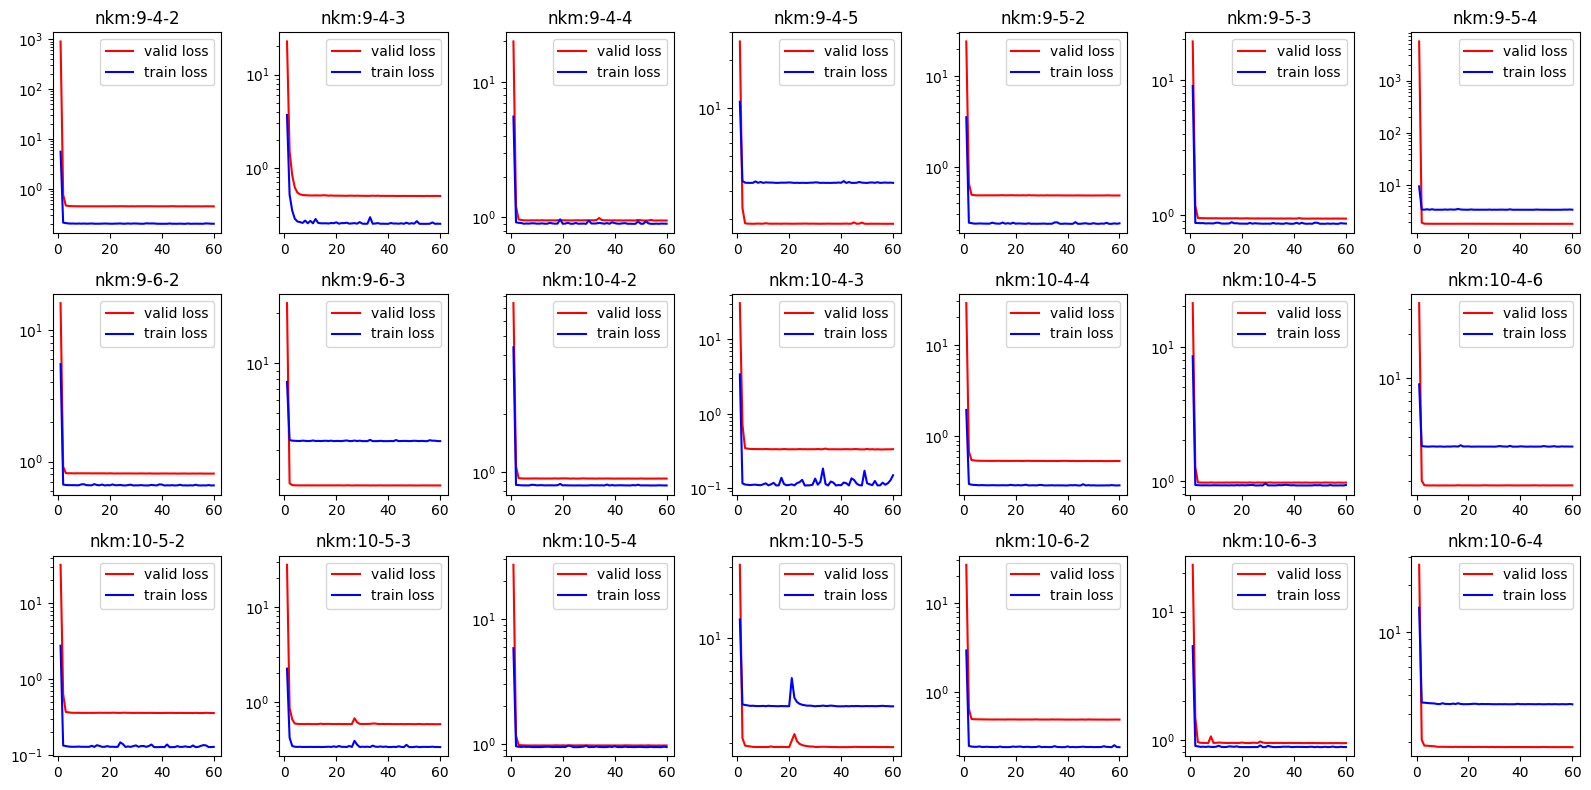

In [12]:
plt.figure(figsize=(16,8))
for i,item in enumerate(nkm):
    n,k,m = item[0], item[1], item[2]
    kl_track = np.load(f'more_feats_kl{n}{k}{m}.npy')
    tr_track = np.load(f'more_feats_vloss{n}{k}{m}.npy')
    val_track = np.load(f'more_feats_tloss{n}{k}{m}.npy')
    
    plt.subplot(3,7,i+1)
    

    plt.plot(range(1,len(val_track)+1),val_track, label = 'valid loss', color = 'red')
    plt.plot(range(1,len(tr_track)+1),tr_track[:], label = 'train loss', color = 'blue')
    plt.title(f'nkm:{n}-{k}-{m}')
    plt.yscale('log')
    plt.legend()

plt.tight_layout()

# loading and Testing each model on its specific dataset

In [9]:
set_seed(42)

input_dim = 30#20#13
latent_dim = 4#2#4#5
output_dim = 1
num_flows = 10#10#4
num_epochs = 50#20 * 2
flow_type = 'planar'  # Choose 'planar' or 'radial'

device = 'cuda' if torch.cuda.is_available() else 'cpu'



all_test_losses = 0
for item in nkm:

    n,k,m = item[0], item[1], item[2]

#     data, target = modif_data_s[[(modif_data_s[:,-1]==item[2]) & (modif_data_s[:,-2]==item[1]) & (modif_data_s[:,-3]==item[0])]], target_vals_s[[(modif_data_s[:,-1]==item[2]) & (modif_data_s[:,-2]==item[1]) & (modif_data_s[:,-3]==item[0])]]
    data, target = modif_data[[(modif_data[:,-1]==item[2]) & (modif_data[:,-2]==item[1]) & (modif_data[:,-3]==item[0])]], target_vals[[(modif_data[:,-1]==item[2]) & (modif_data[:,-2]==item[1]) & (modif_data[:,-3]==item[0])]]


    train_data, val_data, train_targets, val_targets = train_test_split(data, target, test_size=0.2, random_state=42)
    val_data, test_data, val_targets, test_targets = train_test_split(val_data, val_targets, test_size=0.5, random_state=42)

    
    inds = np.where(train_targets < 0.5*1e9) # removing very large values ---> can be outliers
    train_data, train_targets = train_data[inds], train_targets[inds]


    train_dataset = CustomDataset(torch.tensor(train_data), (torch.log2(torch.tensor(train_targets))))
    valid_dataset = CustomDataset(torch.tensor(val_data), torch.tensor(val_targets))
    test_dataset = CustomDataset(torch.tensor(test_data), torch.tensor(test_targets))







    batch_size = 1024 * 2 #256 * 4
    num_workers = 4
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)#, num_workers = num_workers)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)#, num_workers = num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)#, num_workers = num_workers)




    model = VAEWithFlow(input_dim, latent_dim, output_dim, num_flows, flow_type).to(torch.float64).to(device)

    checkpoint = torch.load(f'more_feats_best_model{n}{k}{m}.pth', map_location=torch.device(device)) 
    model.load_state_dict(checkpoint)


    # model.eval()
    # total_val_loss = 0
    # with torch.no_grad():
    #     for x_val, y_val in valid_loader:
    #         x_val,y_val = x_val.to(device), y_val.to(device)
    #         y_hat, z_k, mu, log_var, log_det = model(x_val) # ---> log y hat

    #         # y_hat = torch.round(y_hat)
            
    #         # y_val = torch.log10(torch.log2(y_val)) # ---> since the model predicts the log2 y , and the validation y is not on log 
    #         y_val = torch.log2(y_val) # ---> since the model predicts the log2 y , and the validation y is not on log 
            
    #         ### again, for consistency, similar loss as in training is utilized 
    #         val_loss = F.mse_loss( (((y_val + eps))), ((y_hat.squeeze(-1) + eps)))
    #         total_val_loss += val_loss.item()
    #         val_loss_all.append(val_loss.item())
        
    
    # total_val_loss /= len(valid_loader)

    

    eps = 1e-5
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test,y_test = x_test.to(device), y_test.to(device)
            y_hat, _,_,_,_ = model(x_test) # ---> log2 y
            
            test_loss = F.mse_loss( torch.log2((y_test + eps)), (y_hat.squeeze(-1)))
            
            total_test_loss += test_loss.item()

        total_test_loss /= len(test_loader)

    all_test_losses += total_test_loss/21
    print(f'test error for n={n}, k={k}, m={m}: {total_test_loss}')

print(f'\n <<<<<<<<<<<================================>>>>>>>>>>>> \n\nThe average test loss among all setting is: {all_test_losses}')

C:\Users\amira\AppData\Local\Temp\ipykernel_15828\1878603544.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = CustomDataset(torch.tensor(train_data), (torch.log2(torch.tensor(train_targets))))
C:\Users\amira\AppData\Local\Temp\ipykernel_15828\1878603544.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_dataset = CustomDataset(torch.tensor(val_data), torch.tensor(val_targets))
C:\Users\amira\AppData\Local\Temp\ipykernel_15828\1878603544.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = CustomD

test error for n=9, k=4, m=2: 0.19914556193499
test error for n=9, k=4, m=3: 0.24564016313906387
test error for n=9, k=4, m=4: 0.8989567486764962
test error for n=9, k=4, m=5: 3.4113714396044905
test error for n=9, k=5, m=2: 0.23067422136479226
test error for n=9, k=5, m=3: 0.8673638902748029
test error for n=9, k=5, m=4: 3.45105979785408
test error for n=9, k=6, m=2: 0.6560678592137988
test error for n=9, k=6, m=3: 3.365795997428826
test error for n=10, k=4, m=2: 0.8554715536671678
test error for n=10, k=4, m=3: 0.10951986871024193
test error for n=10, k=4, m=4: 0.29692996083784207
test error for n=10, k=4, m=5: 0.9454339040431081
test error for n=10, k=4, m=6: 3.426969735844606
test error for n=10, k=5, m=2: 0.1252524893880134
test error for n=10, k=5, m=3: 0.3297015241737947
test error for n=10, k=5, m=4: 0.936814005571577
test error for n=10, k=5, m=5: 3.375906578806332
test error for n=10, k=6, m=2: 0.24741990564222566
test error for n=10, k=6, m=3: 0.8933539268384674
test error f

# creating the function for the template 

In [ ]:
!pip install tamu_csce_636_project1

# Please use the following function for evaluating the model

In [ ]:
def ready_to_use_func(n,k,m,p_list, path = 'models/'): ## please save the model where ever you are using the function
    
    # checkpoint = torch.load(f'vaenf_best_perf_model_check{n}{k}{m}.pth', map_location=torch.device(device)) 

    
    #### loading the model 
    model_path = path + f'more_feats_best_model{n}{k}{m}.pth'

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = VAEWithFlow(input_dim=30, latent_dim=4, output_dim=1, num_flows=10, flow_type='planar').to(torch.float64).to(device)
    model_check_point = torch.load(model_path, map_location=torch.device(device))
    model.load_state_dict(model_check_point)    

    # nmks = torch.tensor([[n,m,k] for item in p_list])
    nkms = torch.tensor([[n,k,m] for item in p_list])

    p_list_tensor = torch.tensor(p_list) ### following the instrunctions in the template
    p_list_tensor = p_list_tensor.reshape(-1, p_list_tensor.shape[1] * p_list_tensor.shape[2])
    modif_matrices = pre_process_data(p_list_tensor, nfeat=17)
    
    modif_features = torch.cat([modif_matrices, nkms], axis = 1)
    modif_features = modif_features.to(device).to(torch.float64)

    output = model(modif_features)
    output = 2 ** output ### my model predicts the log2
    return output.flatten().tolist()
